### (1)Import

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST 
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) #set for testing purposes, please do not change! 


## (2)Generator


In [ ]:
# 기본적으로 generator 은 default 로 3 / 2 가 들어감
class Generator (nn.Module):
  def __init__ (self, z_dim=10, im_chan=1,hidden_dim=64):
    super(Generator,self).__init__()
    self.z_dim = z_dim
    # build the neural network
    self.gen = nn.Sequential(
        self.gen_block(z_dim, hidden_dim * 4), #(3,2),
        self.gen_block(hidden_dim *4, hidden_dim *2, kernel_size=4, stride=1),
        self.gen_block(hidden_dim *2, hidden_dim), #(3,2)
        self.gen_block(hidden_dim, im_chan, kernel_size =4, final_layer=True), #(4,2)
    )
  def gen_block(self, in_channel, out_channel, kernel_size =3, stride =2, final_layer = False):
    if not final_layer:
      return nn.Sequential (
          nn.ConvTranspose2d(in_channel, out_channel, kernel_size = kernel_size, stride=stride),
          nn.BatchNorm2d(out_channel),
          nn.ReLU(inplace=True),
      )
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride),
          nn.Tanh(),
      )

  def unsqueeze_noise(self,noise):
    return noise.view(len(noise),self.z_dim,1,1)

  def forward(self,noise):
    x = self.unsqueeze_noise(noise)
    return self.gen(x)

## (3)Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__ (self, im_chan=1, hidden_dim = 16):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        self.disc_block(im_chan, hidden_dim),
        self.disc_block(hidden_dim, hidden_dim *2),
        self.disc_block(hidden_dim *2, 1, final_layer =True ),
    )

  def disc_block(self, in_channel, out_channel, kernel_size =4, stride=2, final_layer =False):
    if not final_layer:
      return nn.Sequential(
          nn.Conv2d(in_channel,out_channel,kernel_size,stride),
          nn.BatchNorm2d(out_channel),
          nn.LeakyReLU(0.2, inplace = True)
      )
    else: # Final Layer
      return nn.Sequential(
          nn.Conv2d(in_channel,out_channel,kernel_size, stride)
      )

  def forward(self, images):
    disc_pred = self.disc(images)
    return disc_pred.view(len(disc_pred),-1)

### (4)noise

In [ ]:
def get_noise(n_samples, z_dim, device ='cpu'):
  return torch.randn(n_samples, z_dim, device=device)

## 기타

### (5-1) 초기화

In [ ]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002

beta_1 = 0.5
beta_2 = 0.999
device = 'cpu'

### (5-2) 데이터 로딩

In [ ]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.5,), (0.5,)),                                 
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### (5-3) 초기화 

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr , betas =(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas =(beta_1,beta_2))

def weights_init(m):
  if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m,nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias,0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

## (6) image display

In [ ]:
def show_tensor_images(image_tensor, num_images = 25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow = 5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## (7) Training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500:Generator loss: 0.9292769365310672,Discriminator loss: 0.5245955131947998


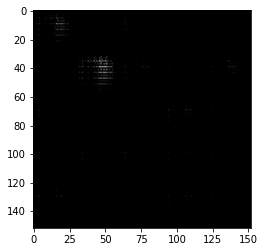

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


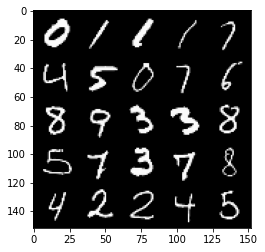

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000:Generator loss: 2.4473787870407095,Discriminator loss: 0.12744853690266594


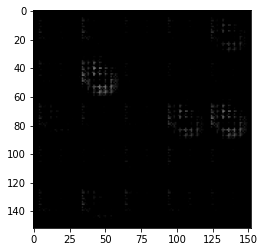

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


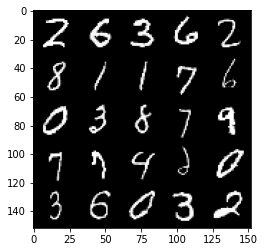

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1500:Generator loss: 3.054962274253368,Discriminator loss: 0.16512330349534762


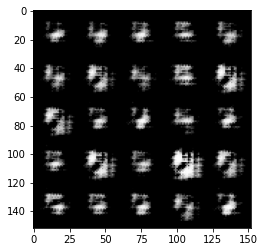

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


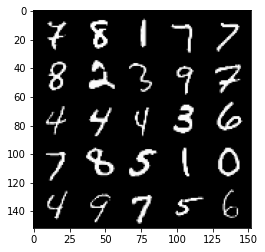

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000:Generator loss: 1.7514113165289185,Discriminator loss: 0.3906023294329646


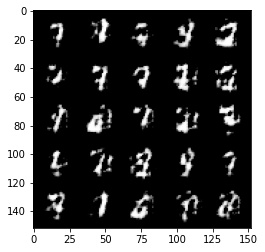

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


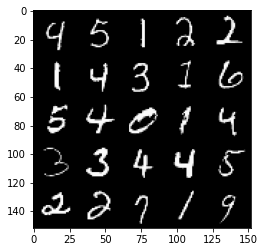

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2500:Generator loss: 1.2726770004928114,Discriminator loss: 0.48034809350967383


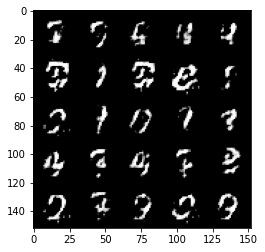

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


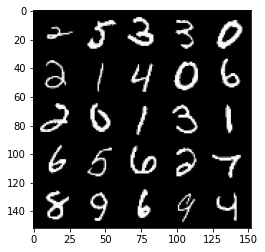

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000:Generator loss: 1.0388876562118539,Discriminator loss: 0.5454360136985779


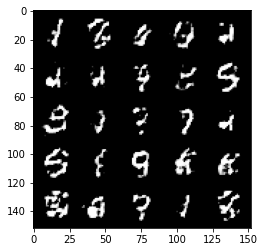

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


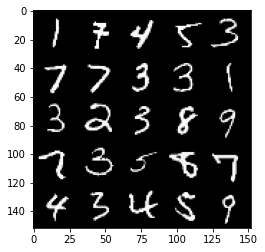

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3500:Generator loss: 0.9251281137466432,Discriminator loss: 0.5866316089034079


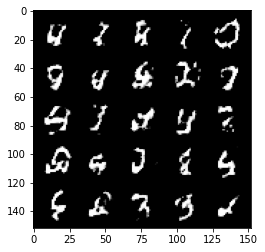

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


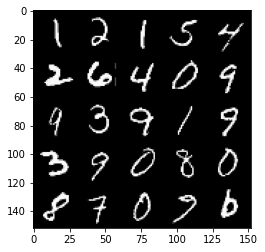

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 4000:Generator loss: 0.8466684185862542,Discriminator loss: 0.614605951905251


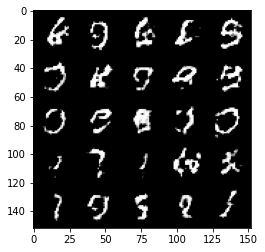

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


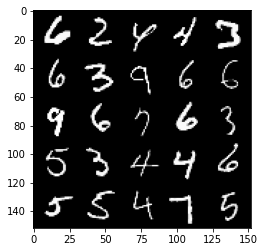

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 4500:Generator loss: 0.841915790081024,Discriminator loss: 0.6292060531377791


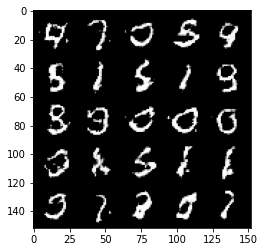

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


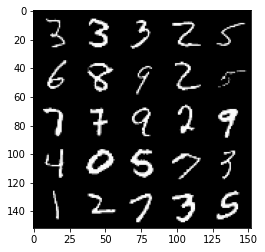

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 5000:Generator loss: 0.8027811111211778,Discriminator loss: 0.6471546078920366


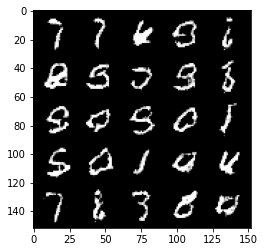

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


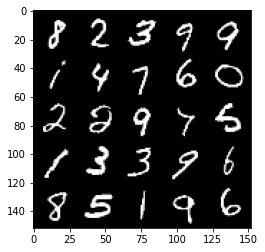

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 5500:Generator loss: 0.794220945179463,Discriminator loss: 0.6496333389282234


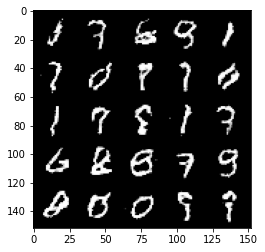

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


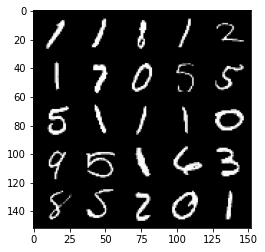

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 6000:Generator loss: 0.792074930667878,Discriminator loss: 0.655695429444313


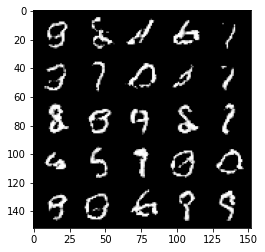

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


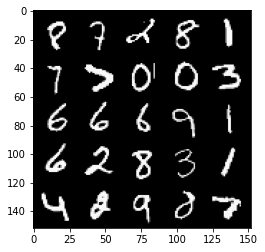

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 6500:Generator loss: 0.7844745128750807,Discriminator loss: 0.6593557976484304


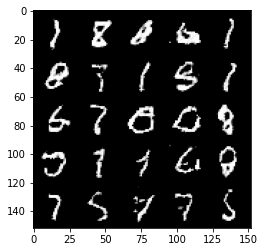

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


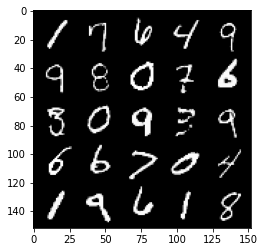

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 7000:Generator loss: 0.7784238994121552,Discriminator loss: 0.6631762958765022


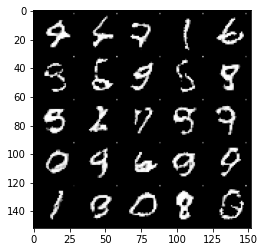

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


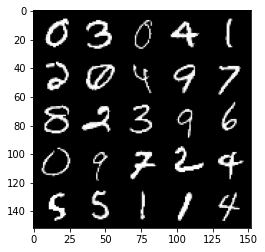

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 7500:Generator loss: 0.7719729514718062,Discriminator loss: 0.6696678079366689


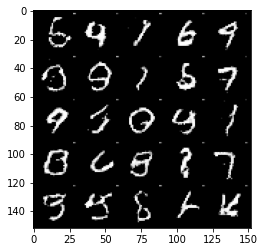

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


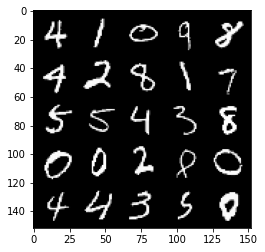

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 8000:Generator loss: 0.7638456364870068,Discriminator loss: 0.6754536001682283


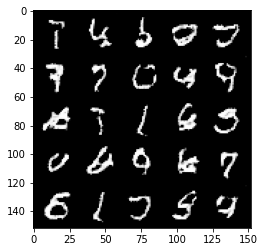

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


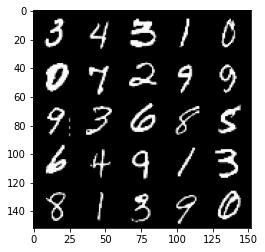

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 8500:Generator loss: 0.7549271003603942,Discriminator loss: 0.6800684731006619


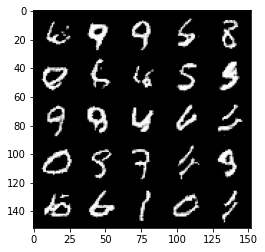

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


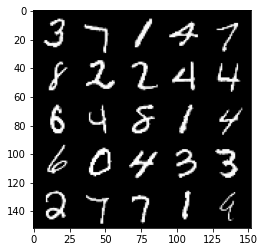

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 9000:Generator loss: 0.7481729345917707,Discriminator loss: 0.6820776128768918


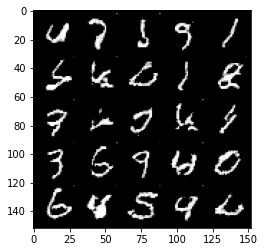

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


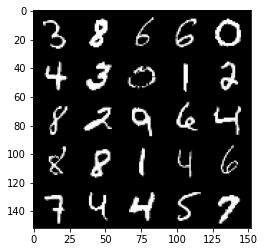

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 9500:Generator loss: 0.7382431346774104,Discriminator loss: 0.6865786999464037


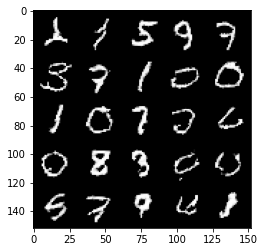

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


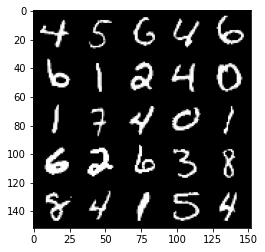

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 10000:Generator loss: 0.734006222188473,Discriminator loss: 0.6885976908206941


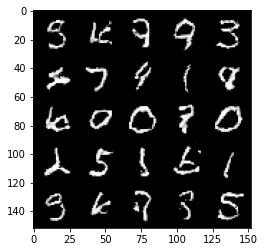

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


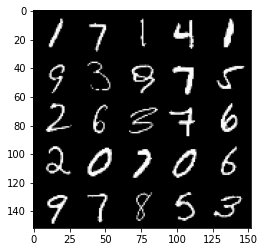

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 10500:Generator loss: 0.7322978210449217,Discriminator loss: 0.6902865370512008


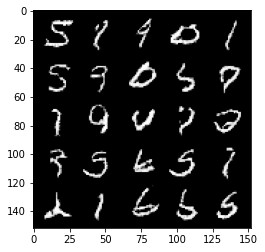

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


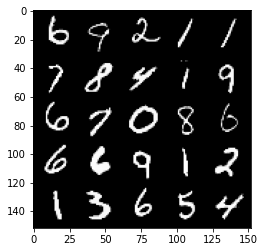

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 11000:Generator loss: 0.7243394146561628,Discriminator loss: 0.6932553343772887


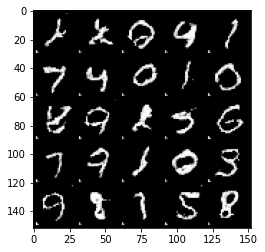

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


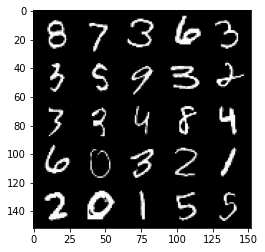

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 11500:Generator loss: 0.7170249043107028,Discriminator loss: 0.6975151450634002


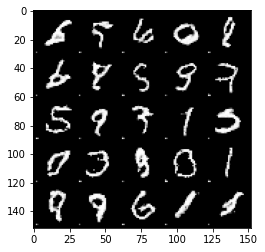

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


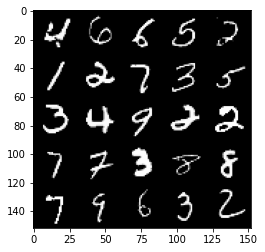

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 12000:Generator loss: 0.7197176356315601,Discriminator loss: 0.696362721681595


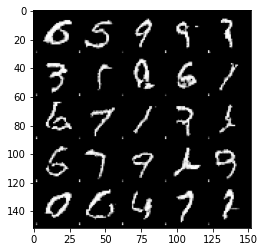

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


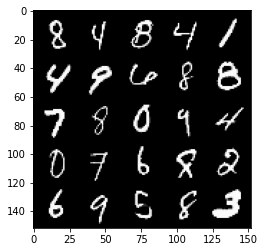

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 12500:Generator loss: 0.7175064800381662,Discriminator loss: 0.6965585969686514


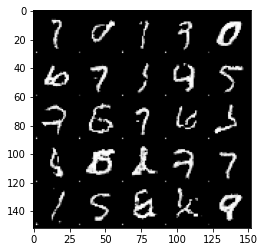

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


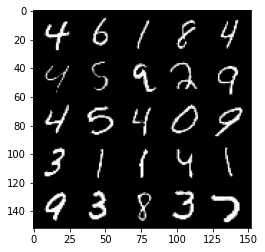

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 13000:Generator loss: 0.7139085595607756,Discriminator loss: 0.6968550536632532


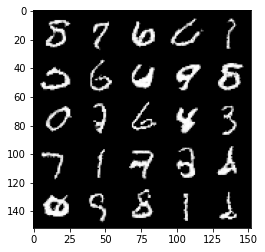

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


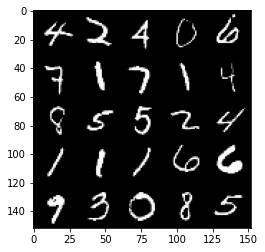

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 13500:Generator loss: 0.7157933253645901,Discriminator loss: 0.6974728267192847


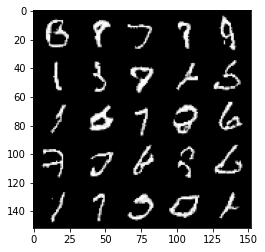

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


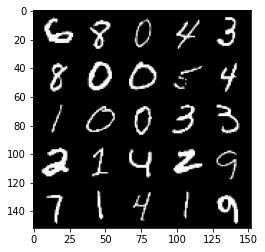

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 14000:Generator loss: 0.7101955249309537,Discriminator loss: 0.6958732872009273


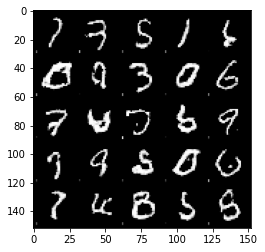

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


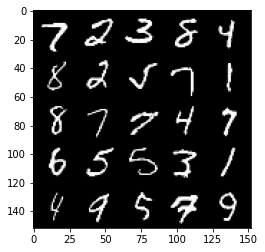

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 14500:Generator loss: 0.7103523672819141,Discriminator loss: 0.6988048729896555


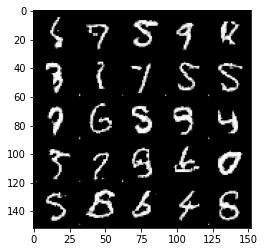

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


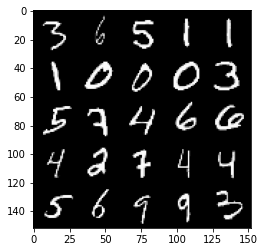

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 15000:Generator loss: 0.7122674953341483,Discriminator loss: 0.6972921351194382


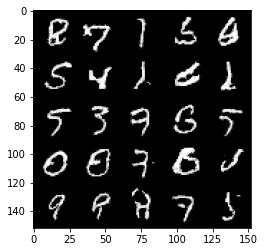

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


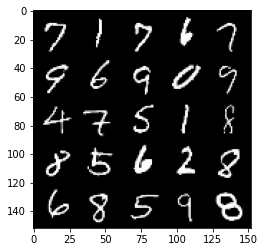

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 15500:Generator loss: 0.7072350346446038,Discriminator loss: 0.698877255558968


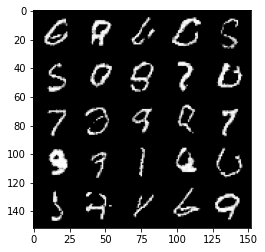

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


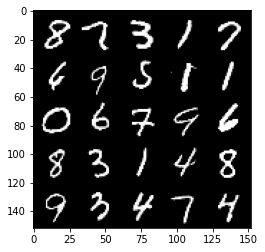

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 16000:Generator loss: 0.7077728535532959,Discriminator loss: 0.6976288825273514


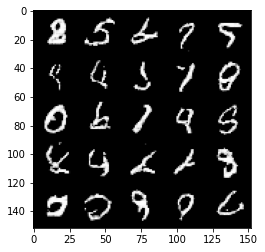

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


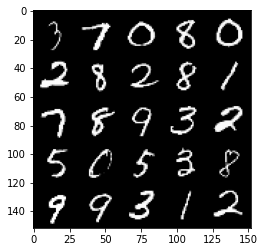

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 16500:Generator loss: 0.7072963136434559,Discriminator loss: 0.6968943659067147


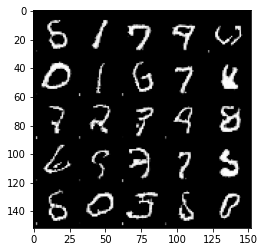

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


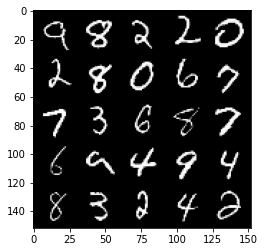

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 17000:Generator loss: 0.7066333580017093,Discriminator loss: 0.6978847173452375


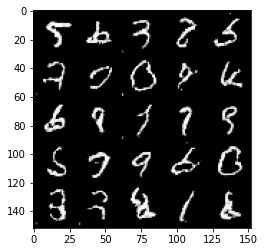

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


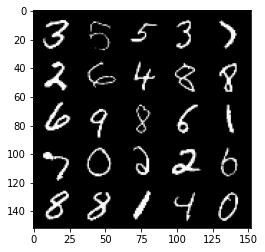

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 17500:Generator loss: 0.7052856199741367,Discriminator loss: 0.6973018774986268


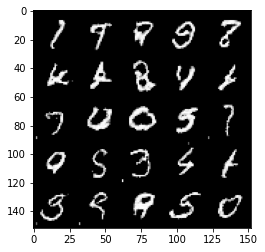

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


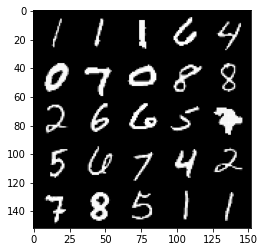

In [ ]:
n_epochs = 50
cur_step = 0 
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
  for real, _ in tqdm(dataloader):
    cur_batch_size = len(real)
    real = real.to(device)

    # update disc
    disc_opt.zero_grad()
    latent = get_noise(cur_batch_size, z_dim, device=device) #z
    fake = gen(latent) # G(z)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss=(disc_fake_loss +disc_real_loss)/2

    # track the average disc loss
    mean_discriminator_loss += disc_loss.item()/display_step
    disc_loss.backward(retain_graph = True)
    disc_opt.step()

    #update gen 
    gen_opt.zero_grad()
    latent_2 = get_noise(cur_batch_size,z_dim, device=device) #z
    fake_2 = gen(latent_2)
    disc_fake_pred = disc(fake_2) # D(G(z)) /#detach 뺌으로써 미분 사용 
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    gen_loss.backward()
    gen_opt.step()

    # Track the average gen loss
    mean_generator_loss += gen_loss.item()/display_step

    #visualize the results
    if cur_step % display_step == 0 and cur_step >0:
      print(f"Step {cur_step}:Generator loss: {mean_generator_loss},Discriminator loss: {mean_discriminator_loss}")
      show_tensor_images(fake)
      show_tensor_images(real)
      mean_generator_loss = 0
      mean_discriminator_loss = 0
    cur_step +=1 